In [332]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import random
import datetime
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torch.utils.data import TensorDataset, DataLoader
from torchvision import transforms
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [89]:
csv_file = '../data/cat_dog.csv'
data = pd.read_csv(csv_file)

In [90]:
image_paths = [os.path.join('../data/cat_dog', img_name) for img_name in data['image']]
labels = data['labels'].tolist()

## Предварительный анализ данных

In [91]:
def show_one_image_per_class(image_paths, labels):
    classes = set(labels)
    num_classes = len(classes)
    fig, axs = plt.subplots(1, num_classes, figsize=(5*num_classes, 5))

    for i, cls in enumerate(classes):
        class_images = [img_path for img_path, label in zip(image_paths, labels) if label == cls]
        sample_image = random.choice(class_images)

        img = plt.imread(sample_image)
        axs[i].imshow(img)
        axs[i].set_title(f'Class: {cls}')
        axs[i].axis('off')

    plt.tight_layout()
    plt.show()

In [92]:
def plot_class_distribution(labels):
    class_counts = {label: labels.count(label) for label in set(labels)}

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.bar(class_counts.keys(), class_counts.values())
    plt.xlabel('Class')
    plt.ylabel('Number of Images')
    plt.title('Class Distribution (Histogram)')

    plt.subplot(1, 2, 2)
    plt.pie(class_counts.values(), labels=class_counts.keys(), autopct='%1.1f%%')
    plt.title('Class Distribution (Pie Chart)')
    
    plt.tight_layout()
    plt.show()

In [93]:
def get_image_sizes(image_paths):
    sizes = []
    for img_path in image_paths:
        img = plt.imread(img_path)
        sizes.append(img.shape[:2])
    return sizes

In [94]:
def plot_image_sizes(image_paths):
    sizes = get_image_sizes(image_paths)
    width = [size[0] for size in sizes]
    height = [size[1] for size in sizes]

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.hist(width, bins=30, color='b', alpha=0.7)
    plt.xlabel('Width')
    plt.ylabel('Frequency')
    plt.title('Width Distribution')

    plt.subplot(1, 2, 2)
    plt.hist(height, bins=30, color='r', alpha=0.7)
    plt.xlabel('Height')
    plt.ylabel('Frequency')
    plt.title('Height Distribution')

    plt.tight_layout()
    plt.show()

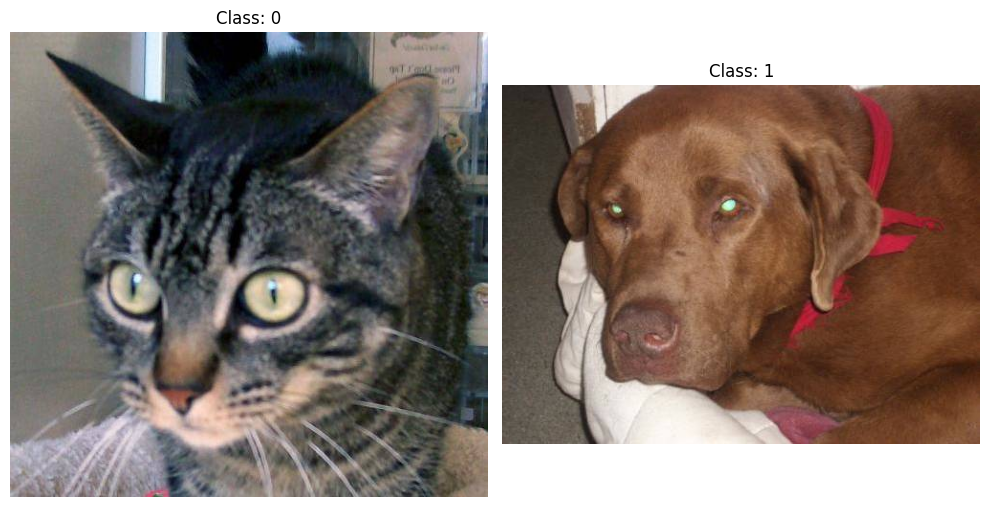

In [95]:
show_one_image_per_class(image_paths, labels)

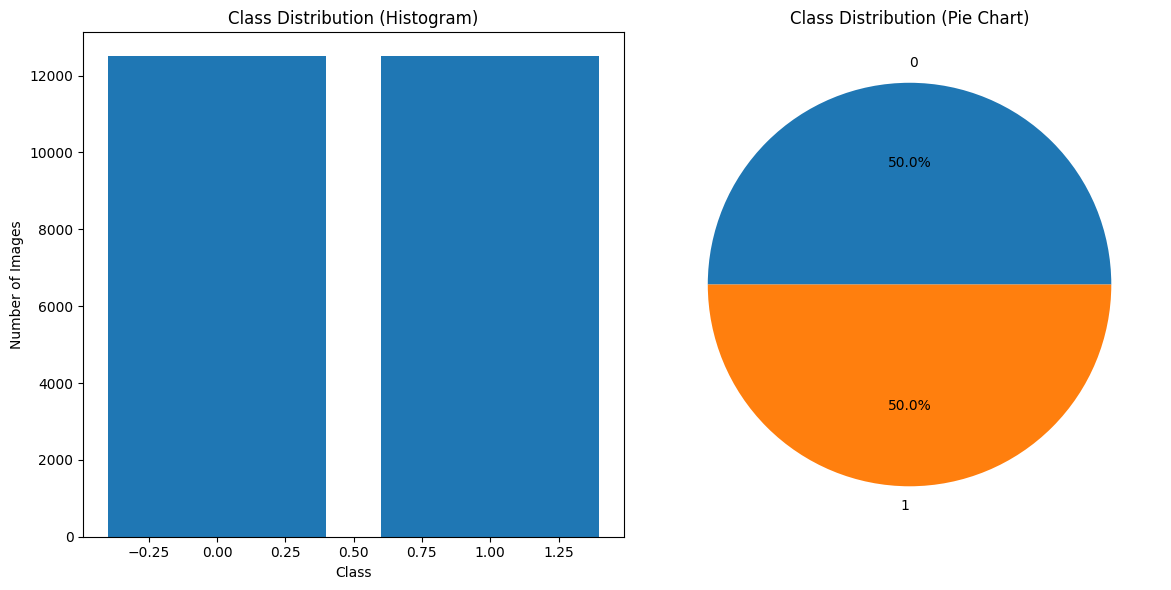

In [96]:
plot_class_distribution(labels)

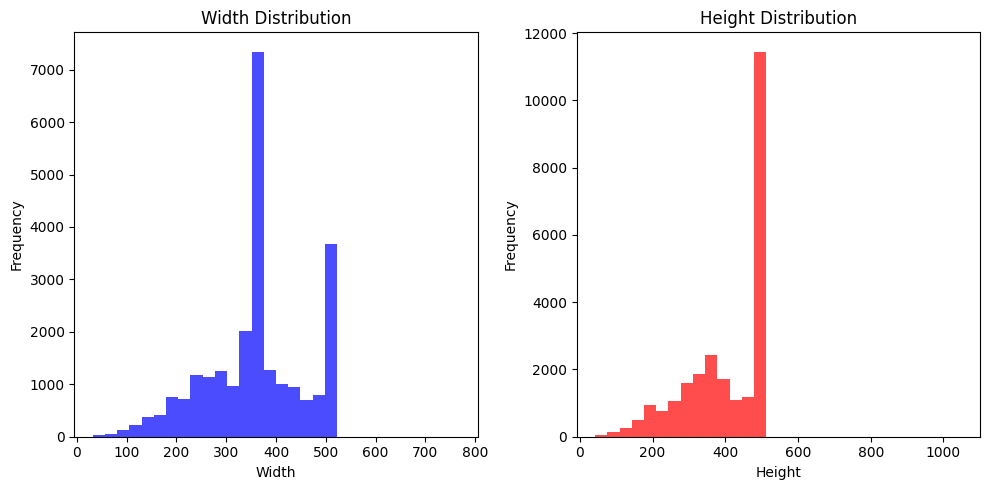

In [97]:
plot_image_sizes(image_paths)

## Подготовка данных

In [98]:
new_width = 64
new_height = 64

data_transform = transforms.Compose([
    transforms.Resize((new_width, new_height)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

transformed_images = [data_transform(Image.open(img_path)) for img_path in image_paths]

In [99]:
train_data, val_test_data, train_labels, val_test_labels = train_test_split(transformed_images, labels, train_size=0.7, random_state=42, stratify=labels)

val_data, test_data, val_labels, test_labels = train_test_split(val_test_data, val_test_labels, train_size=0.5, random_state=42, stratify=val_test_labels)

In [100]:
len(train_data), len(val_data), len(test_data)

(17500, 3750, 3750)

In [101]:
train_data_tensor = torch.stack(train_data)
val_data_tensor = torch.stack(val_data)
test_data_tensor = torch.stack(test_data)

train_labels_tensor = torch.tensor(train_labels)
val_labels_tensor = torch.tensor(val_labels)
test_labels_tensor = torch.tensor(test_labels)

In [102]:
train_dataset = TensorDataset(train_data_tensor, train_labels_tensor)
val_dataset = TensorDataset(val_data_tensor, val_labels_tensor)
test_dataset = TensorDataset(test_data_tensor, test_labels_tensor)

batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

## Моделирование

In [318]:
class CNNNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(32, 16, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2)
        self.conv3 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(2)
        self.conv4 = nn.Conv2d(8, 4, kernel_size=3, padding=1)
        self.pool4 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(4 * 4 * 4, 32)
        self.fc2 = nn.Linear(32, 2)
        self.act = nn.ReLU()

    def forward(self, x):
        out = self.pool1(self.act(self.conv1(x)))
        out = self.pool2(self.act(self.conv2(out)))
        out = self.pool3(self.act(self.conv3(out)))
        out = self.pool4(self.act(self.conv4(out)))
        out = out.view(-1, 4 * 4 * 4)
        out = self.act(self.fc1(out))
        out = self.fc2(out)
        
        return out

In [ ]:
pretrained_model = models.resnet18(pretrained=True)
num_ftrs = pretrained_model.fc.in_features
pretrained_model.fc = nn.Linear(num_ftrs, 2)

In [168]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [169]:
def training_loop(n_epochs, model, optimizer, criterion, train_loader, val_loader):
    train_losses = []
    val_losses = []
    for epoch in range(n_epochs):
        loss_train = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            loss_train += loss.item()
            
        avg_loss_train = loss_train / len(train_loader)
        train_losses.append(avg_loss_train)
        
        loss_val = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss_val += criterion(outputs, labels).item()
            
            avg_loss_val = loss_val / len(val_loader)
            val_losses.append(avg_loss_val)

        print('{} Epoch {}, Training loss: {:.4f}'.format(datetime.datetime.now(), epoch + 1, avg_loss_train))
        print('{} Epoch {}, Validation loss: {:.4f}'.format(datetime.datetime.now(), epoch + 1, avg_loss_val))

    return train_losses, val_losses

In [170]:
def plot_losses(train_losses, val_losses):
    plt.plot(train_losses, label='Training loss')
    plt.plot(val_losses, label='Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

In [171]:
def evaluate_model(model, data_loader):
    loss = 0.0
    correct = 0.0
    total = 0.0

    model.eval()
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            output = model(images)
            loss += criterion(output, labels).item()
            _, predicted = torch.max(output.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_loss = loss / len(data_loader)
    accuracy = 100 * correct / total

    return avg_loss, accuracy

#### Кастомная модель

In [319]:
n_epochs = 25
model = CNNNet()
criterion = nn.CrossEntropyLoss()
learning_rate = 0.0007
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [320]:
train_losses, val_losses = training_loop(n_epochs, model, optimizer, criterion, train_loader, val_loader)

2024-05-01 23:00:55.853947 Epoch 1, Training loss: 0.6671
2024-05-01 23:00:55.854066 Epoch 1, Validation loss: 0.6458
2024-05-01 23:01:26.351353 Epoch 2, Training loss: 0.6156
2024-05-01 23:01:26.351463 Epoch 2, Validation loss: 0.5898
2024-05-01 23:01:56.892783 Epoch 3, Training loss: 0.5775
2024-05-01 23:01:56.892896 Epoch 3, Validation loss: 0.5721
2024-05-01 23:02:28.604125 Epoch 4, Training loss: 0.5550
2024-05-01 23:02:28.604229 Epoch 4, Validation loss: 0.5508
2024-05-01 23:02:59.136780 Epoch 5, Training loss: 0.5351
2024-05-01 23:02:59.136887 Epoch 5, Validation loss: 0.5420
2024-05-01 23:03:31.841530 Epoch 6, Training loss: 0.5201
2024-05-01 23:03:31.841661 Epoch 6, Validation loss: 0.5223
2024-05-01 23:04:02.886058 Epoch 7, Training loss: 0.5060
2024-05-01 23:04:02.886190 Epoch 7, Validation loss: 0.5168
2024-05-01 23:04:34.516655 Epoch 8, Training loss: 0.4895
2024-05-01 23:04:34.516771 Epoch 8, Validation loss: 0.5112
2024-05-01 23:05:06.063887 Epoch 9, Training loss: 0.478

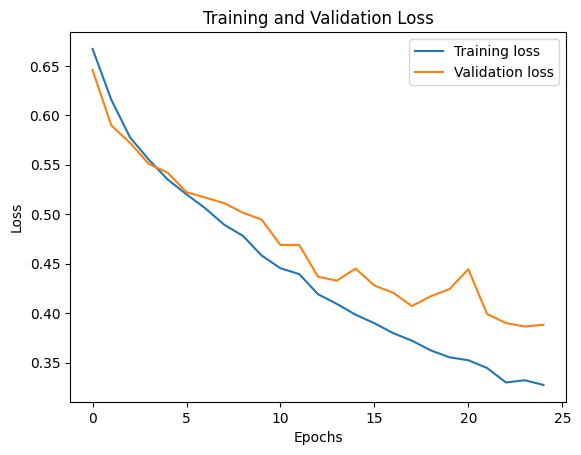

In [321]:
plot_losses(train_losses, val_losses)

In [322]:
evaluate_model(model, val_loader)

(0.38825407977831566, 82.10666666666667)

In [326]:
model.eval()
predictions = []
test_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        predictions.extend(outputs.tolist())
        test_labels.extend(labels.tolist())

probs = torch.tensor(predictions)
predicted_classes = torch.argmax(probs, dim=1)

In [327]:
print(classification_report(predicted_classes, test_labels))

              precision    recall  f1-score   support

           0       0.81      0.84      0.83      1813
           1       0.85      0.82      0.83      1937

    accuracy                           0.83      3750
   macro avg       0.83      0.83      0.83      3750
weighted avg       0.83      0.83      0.83      3750



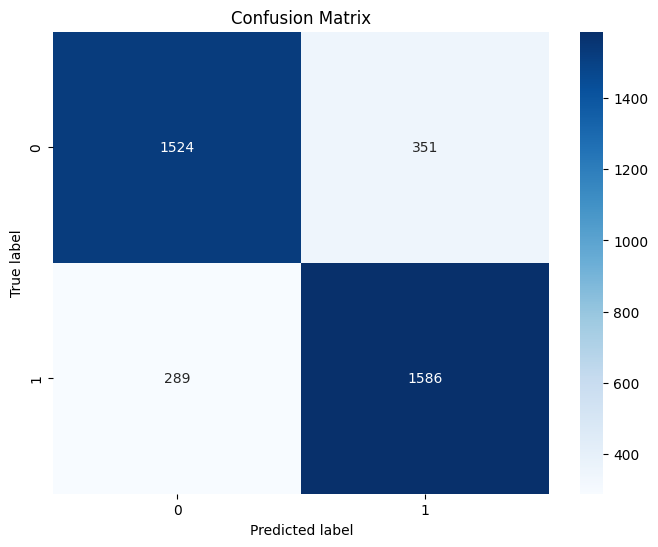

In [328]:
conf_matrix = confusion_matrix(test_labels, predicted_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

#### Предобученная модель

In [378]:
n_epochs = 6
model = pretrained_model
criterion = nn.CrossEntropyLoss()
learning_rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [379]:
train_losses, val_losses = training_loop(n_epochs, model, optimizer, criterion, train_loader, val_loader)

2024-05-02 01:05:52.140441 Epoch 1, Training loss: 0.0828
2024-05-02 01:05:52.140589 Epoch 1, Validation loss: 0.3170
2024-05-02 01:09:45.293017 Epoch 2, Training loss: 0.0574
2024-05-02 01:09:45.293124 Epoch 2, Validation loss: 0.4321
2024-05-02 01:13:39.425736 Epoch 3, Training loss: 0.0537
2024-05-02 01:13:39.425846 Epoch 3, Validation loss: 0.5107
2024-05-02 01:17:30.280756 Epoch 4, Training loss: 0.0503
2024-05-02 01:17:30.280865 Epoch 4, Validation loss: 0.3701
2024-05-02 01:21:24.222379 Epoch 5, Training loss: 0.0469
2024-05-02 01:21:24.222497 Epoch 5, Validation loss: 0.4949
2024-05-02 01:25:17.532068 Epoch 6, Training loss: 0.0400
2024-05-02 01:25:17.532197 Epoch 6, Validation loss: 0.4434


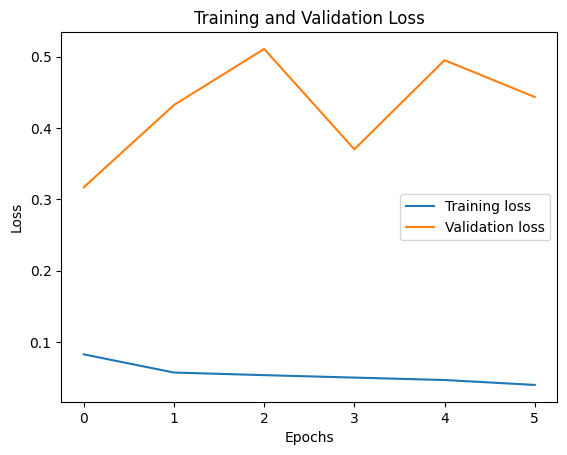

In [380]:
plot_losses(train_losses, val_losses)

In [381]:
evaluate_model(model, val_loader)

(0.4433746008297144, 89.65333333333334)

In [382]:
model.eval()
predictions = []
test_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        predictions.extend(outputs.tolist())
        test_labels.extend(labels.tolist())

probs = torch.tensor(predictions)
predicted_classes = torch.argmax(probs, dim=1)

In [383]:
print(classification_report(predicted_classes, test_labels))

              precision    recall  f1-score   support

           0       0.87      0.92      0.89      1786
           1       0.92      0.88      0.90      1964

    accuracy                           0.90      3750
   macro avg       0.90      0.90      0.90      3750
weighted avg       0.90      0.90      0.90      3750



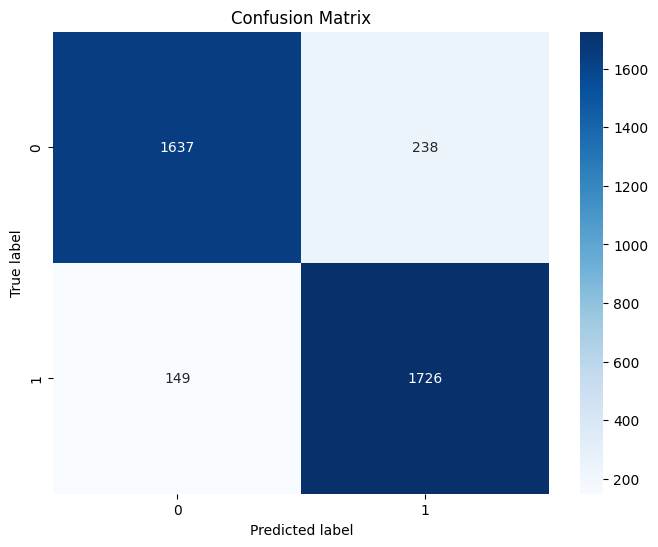

In [384]:
conf_matrix = confusion_matrix(test_labels, predicted_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

## Отчет по исследованию нейронных сетей для классификации изображений собак и кошек

#### Введение

Цель данного исследования состоит в разработке и оценке различных моделей нейронных сетей для классификации изображений собак и кошек. Данная задача является классической задачей компьютерного зрения.

#### Методы

В данном исследовании использовались следующие методы:

Загрузка и предобработка данных.
Создание и обучение кастомной нейронной сети с использованием сверточных и полносвязных слоев.
Использование предобученной модели ResNet18, с заменой последнего полносвязного слоя для адаптации к задаче классификации собак и кошек.
Обучение моделей на тренировочном наборе данных и валидация на валидационном наборе данных.
Оценка производительности моделей на тестовом наборе данных с помощью метрик точности, полноты, F1-меры и confusion matrix.
Эксперименты

Исследование проводилось на наборе данных, содержащем изображения собак и кошек. Данные были предварительно обработаны и разделены на тренировочный, валидационный и тестовый наборы.

#### Результаты

Кастомная нейронная сеть показала точность на уровне 83% на тестовом наборе данных.
Предобученная модель ResNet18 показала более высокую точность на уровне 90% на тестовом наборе данных.
Обсуждение

Результаты показывают, что использование предобученных моделей может значительно повысить производительность нейронных сетей на задаче классификации изображений собак и кошек. Более того, результаты подтверждают важность выбора правильных архитектур и гиперпараметров для достижения высокой производительности модели.

#### Заключение

Исследование позволяет сделать вывод о том, что для задачи классификации изображений собак и кошек эффективнее использовать предобученные модели нейронных сетей. Дальнейшие исследования могут быть направлены на тонкую настройку гиперпараметров и архитектур моделей для еще более высокой производительности.